In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
import warnings
warnings.filterwarnings("ignore")


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=None).to(device)
  
# 3. Freeze the base parameters
#for parameter in pretrained_vit.parameters():
#    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['label_1','label_3','label_4','label_5','label_6','label_7','label_8']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [3]:
#deepseek###########################################################
pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT

# 2. Setup ViT-Large model
pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['label_1','label_3','label_4','label_5','label_6','label_7','label_8']
set_seeds()
# 3. Modify classifier head (note in_features=1024 for Large)
pretrained_vit.heads = nn.Linear(in_features=1024, 
                                out_features=len(class_names)).to(device)

In [3]:
# 1. Get pretrained weights for ViT-Huge (14x14 patches)
pretrained_vit_weights = torchvision.models.ViT_H_14_Weights.DEFAULT

# 2. Setup ViT-Huge model
pretrained_vit = torchvision.models.vit_h_14(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['label_1','label_3','label_4','label_5','label_6','label_7','label_8']
set_seeds()
# 3. Modify classifier head (note in_features=1280 for Huge)
pretrained_vit.heads = nn.Linear(in_features=1280, 
                                out_features=len(class_names)).to(device)

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(16, 3, 224,224), # (batch_size, color_channels, height, width) defaut :input_size=(16, 3, 224, 224)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 7]              768                  True
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 197, 76

In [5]:
# Setup directory paths to train and test images
train_dir = 'seperated_heatmap_data/train'
test_dir = 'seperated_heatmap_data/valid'

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=16) # Could increase if we had more samples)

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4821 | train_acc: 0.4211 | test_loss: 1.2779 | test_acc: 0.4284
Epoch: 2 | train_loss: 1.2659 | train_acc: 0.4824 | test_loss: 0.9778 | test_acc: 0.5694
Epoch: 3 | train_loss: 1.0943 | train_acc: 0.5590 | test_loss: 0.9903 | test_acc: 0.5181


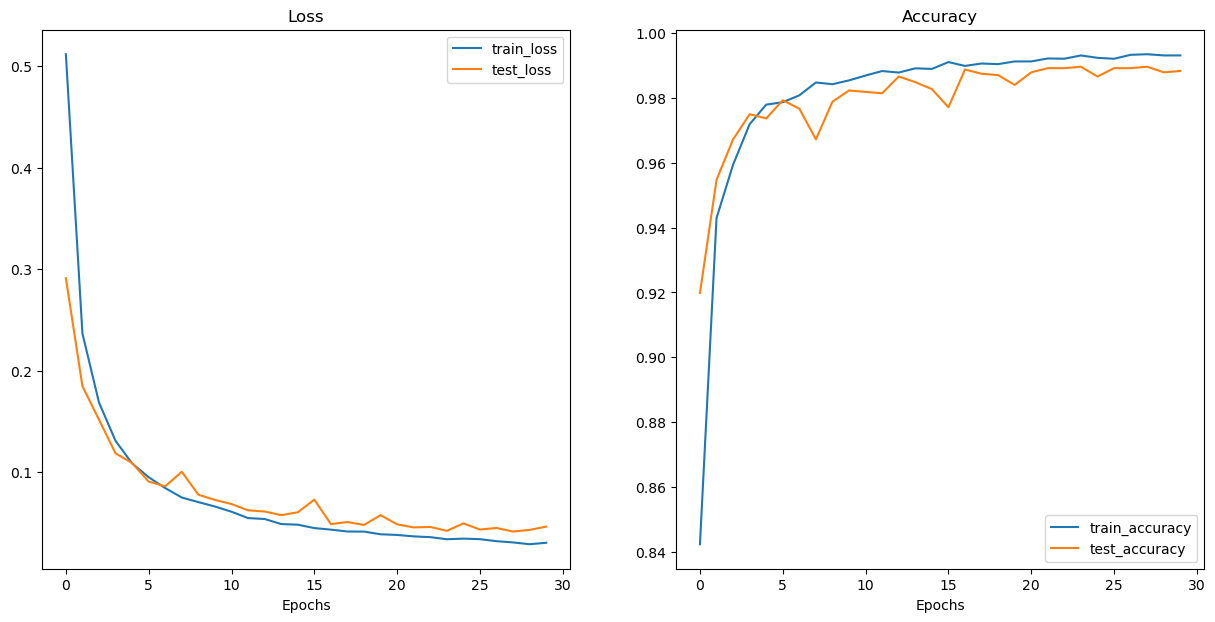

In [10]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

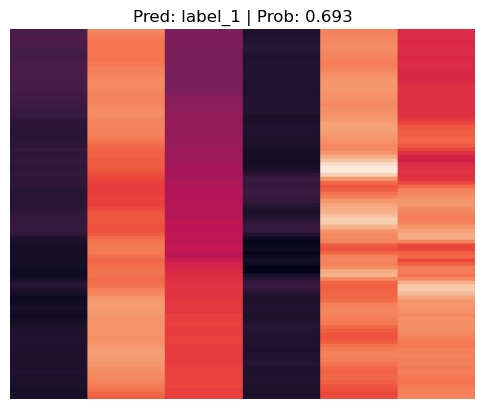

In [11]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "501_heatmap_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [12]:
 torch.save(pretrained_vit,"30_epoch_VIT_base_model.pt")

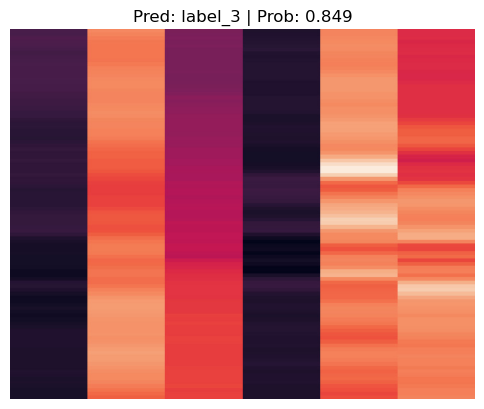

In [14]:
the_model = torch.load("50_epoch_VIT_large_model.pt")
pred_and_plot_image(model=the_model,
                    image_path=custom_image_path,
                    class_names=class_names)